In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from correlation_estimators import calculate_pearson
from sampling import pps, accept_reject
from scipy.stats.distributions import norm, expon

PROPERTY = 'fire_size'

dfo = pd.read_csv('./data/FW_Veg_Rem_Combined.csv')

cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]

def preprocess_missing_weather_data(df):
    df_subsample = df[df['Temp_pre_7'] == -1]
    df_clean = df[df['Temp_pre_7'] != -1]
    mean_weather_data = df_clean.groupby(['state', 'discovery_month'])[weather_columns].mean().reset_index()
    df_subsample.drop(weather_columns, axis=1, inplace=True)
    df_subsample = df_subsample.merge(mean_weather_data)
    df_clean = df_clean.append(df_subsample, ignore_index=True)
    return df_clean

df = preprocess_missing_weather_data(dfo)
df_full = df
df = pps(df, PROPERTY, 0.1)

df['fire_size'] = np.log(df['fire_size'])

df.shape[0]

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_62855/3321096114.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fire_size'] = np.log(df['fire_size'])


7835

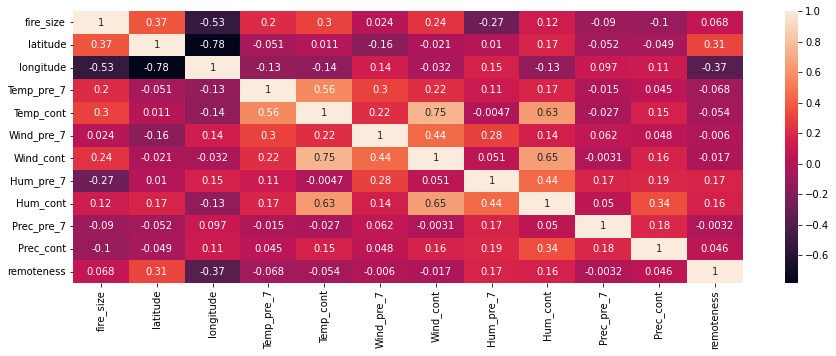

In [3]:
#correlation_matrix_min

to_drop = list(set(df.columns) - set(['fire_size', 'Temp_pre_7', 'Hum_pre_7', 'Wind_pre_7', 'Prec_pre_7', 'remoteness', 'latitude', 'longitude', 'Temp_cont', 'Hum_cont', 'Wind_cont', 'Prec_cont']))

df_min = df.drop(to_drop, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(df_min.corr(), annot = True, ax=ax)
plt.show()

In [4]:
#BAsesian network preparation

!git clone https://github.com/ITMO-NSS-team/BAMT.git
!pip install -r BAMT/requirements.txt

import os, sys

sys.path.append(os.path.join(os.path.dirname('./BAMT'), "BAMT"))

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

fatal: destination path 'BAMT' already exists and is not an empty directory.


In [5]:
bayesian_net_columns = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'fire_size', 'Hum_pre_30', 'stat_cause_descr']
bayesian_net_columns_cont = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30', 'fire_size']
to_drop = filter(lambda col: col != PROPERTY and not col in bayesian_net_columns, df.columns)

df_bayes = df.drop(to_drop, axis=1)
df_bayes['stat_cause_descr'] = df_bayes['stat_cause_descr'].apply(lambda x: str(x))

for col in bayesian_net_columns_cont:
    df_bayes[col] = df_bayes[col].apply(lambda x: float(x))

df_bayes.dropna(inplace=True)
df_bayes.reset_index(inplace=True, drop=True)
df_bayes.head(10)

,fire_size,stat_cause_descr,latitude,longitude,Temp_pre_30,Temp_pre_15,Temp_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,remoteness
0,3.407179,Debris Burning,31.259000,-84.895600,20.079480,17.722714,18.188679,67.551783,61.733788,60.328571,0.0,0.162416
1,2.727853,Equipment Use,36.586500,-96.323220,8.523263,5.933658,2.911842,76.615217,80.177291,85.369369,150.8,0.263943
2,1.609438,Equipment Use,32.275940,-102.760900,6.224290,8.950698,8.880240,44.628895,32.515977,37.246939,0.0,0.327901
3,1.648659,Miscellaneous,33.426303,-84.925226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.161130
4,0.000000,Arson,40.746111,-75.748611,9.215850,9.625352,11.323707,66.972917,63.144681,65.285047,182.8,0.076025
5,2.302585,Arson,33.370210,-98.447810,8.372812,7.059375,8.493939,61.569249,71.109474,78.982301,86.5,0.285984
6,1.335001,Debris Burning,44.524631,-88.996043,0.578848,6.130116,7.645339,71.180254,68.552326,65.423729,40.2,0.192649
7,1.609438,Debris Burning,31.560615,-96.291583,10.410706,13.517045,11.311230,63.708520,63.083721,56.908108,22.7,0.266943
8,2.302585,Debris Burning,30.823796,-96.380568,28.834016,29.230492,29.885828,67.982322,65.747159,66.590818,0.0,0.268336
9,2.564949,Debris Burning,34.080486,-83.861637,6.950617,0.000000,0.000000,58.975309,0.000000,0.000000,0.0,0.151147


In [6]:
nodes_type = get_nodes_type(df_bayes)
nodes_sign = get_nodes_sign(df_bayes)

nodes_type
nodes_sign

{'fire_size': 'neg',
 'latitude': 'pos',
 'longitude': 'neg',
 'Temp_pre_30': 'neg',
 'Temp_pre_15': 'neg',
 'Temp_pre_7': 'neg',
 'Hum_pre_30': 'pos',
 'Hum_pre_15': 'pos',
 'Hum_pre_7': 'pos',
 'Prec_pre_30': 'pos',
 'remoteness': 'pos'}

In [7]:
coded_data, coder = code_categories(df_bayes, 'label', ['stat_cause_descr'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', bayesian_net_columns_cont)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [8]:
#bn_hc_k2 = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
#save_structure(bn_hc_k2, 'struct_bnhc_firesize_log')
#bn_hc_params = parameter_learning(discrete_data, nodes_type, bn_hc_k2, 'simple')
#save_params(bn_hc_params, 'params_bnhc_firesize_log')

bn_hc = read_structure('struct_bnhc_firesize_log')
bn_hc_params = read_params('params_bnhc_firesize_log')


bayes_hc = HyBayesianNetwork(bn_hc, bn_hc_params)

In [9]:
#bn_evo_k2 = structure_learning(discrete_data, 'evo', nodes_type)
#save_structure(bn_evo_k2, 'struct_evok2_firesize_log')
#bn_evo_params = parameter_learning(discrete_data, nodes_type, bn_evo_k2, 'simple')
#save_params(bn_evo_params, 'params_evok2_firesize_log')

bn_evo_k2 = read_structure('struct_evok2_firesize_log')
bn_evo_params = read_params('params_evok2_firesize_log')

bayes_evok2 = HyBayesianNetwork(bn_evo_k2, bn_evo_params)

In [10]:
#bn_evo_mi = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
#save_structure(bn_evo_mi, 'struct_evomi_firesize_log')
#bn_evomi_params = parameter_learning(discrete_data, nodes_type, bn_evo_mi, 'mix')
#save_params(bn_evomi_params, 'params_evomi_firesize_log')

bn_evo_mi = read_structure('struct_evomi_firesize_log')
bn_evomi_params = read_params('params_evomi_firesize_log')

bayes_evomi = HyBayesianNetwork(bn_evo_mi, bn_evomi_params)

In [11]:
df_val = df_bayes.sample(frac=0.01)
df_val.shape[0]


78

In [12]:
params_manual = read_params('params_manual')
struct_manual = read_structure('struct_manual')


bayes_man = HyBayesianNetwork(struct_manual, params_manual)

In [13]:
#stats and predictions MANUALL

synth_data_man = generate_synthetics(bayes_man, nodes_sign, 'simple', 1200)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_man['fire_size'], ax=ax)
ax.legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()

IndexError: list index out of range

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
RMDS is ({}, {'fire_size': 3.93})


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


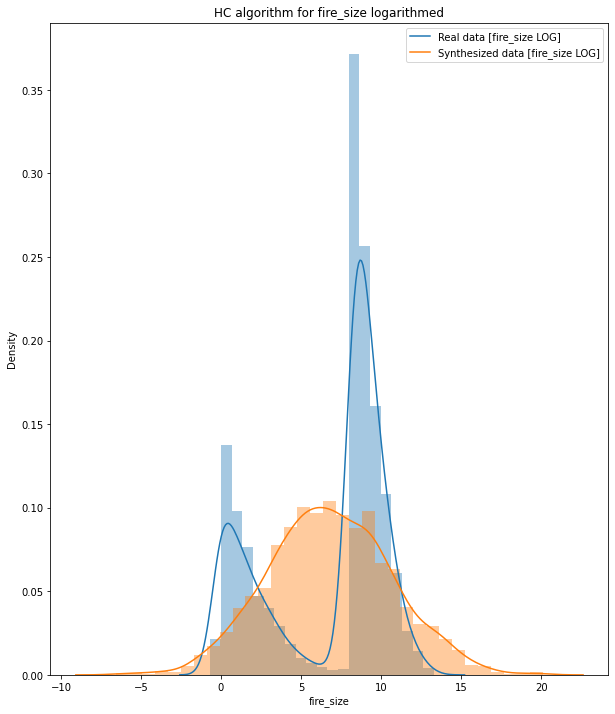

In [15]:
#stats and predictions

answ_hc =  calculate_acc(bayes_hc, df_val, ['fire_size'], 'simple')

synth_data_hc = generate_synthetics(bayes_hc, nodes_sign, 'simple', 2000)

print(f'RMDS is {answ_hc[0:2]}')

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_hc['fire_size'], ax=ax)
ax.legend(['Real data [fire_size LOG]', 'Synthesized data [fire_size LOG]'])
plt.title('HC algorithm for fire_size logarithmed')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
RMDS is {'fire_size': 37.127}


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


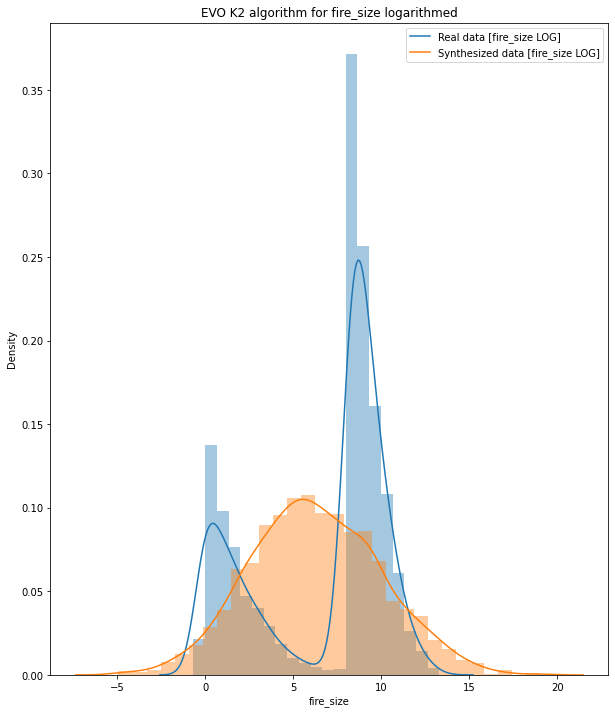

In [16]:

answ_evok2 =  calculate_acc(bayes_evok2, df_val, ['fire_size'], 'simple')

synth_data_evok2 = generate_synthetics(bayes_evok2, nodes_sign, 'simple', 2000)

print(f'RMDS is {answ_evok2[1]}')

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_evok2['fire_size'], ax=ax)
ax.legend(['Real data [fire_size LOG]', 'Synthesized data [fire_size LOG]'])
plt.title('EVO K2 algorithm for fire_size logarithmed')
plt.show()

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


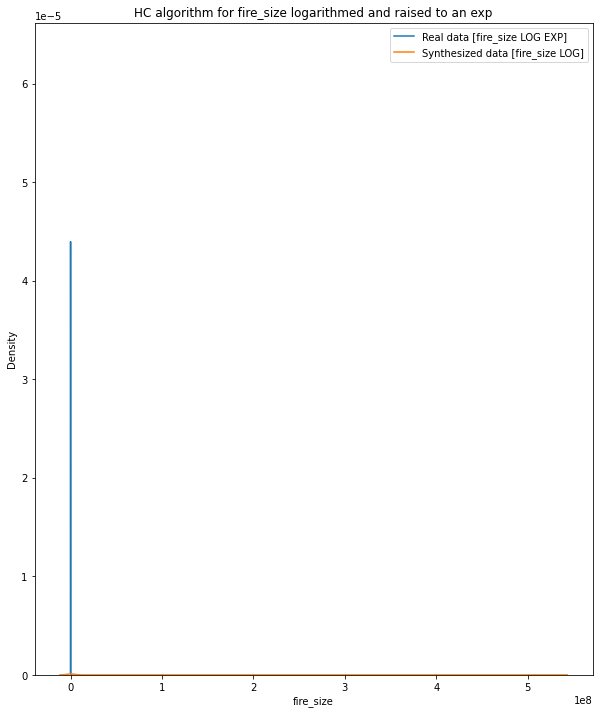

In [17]:
fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(np.exp(df_bayes['fire_size']), ax=ax)
sns.distplot(np.exp(synth_data_hc['fire_size']), ax=ax)
ax.legend(['Real data [fire_size LOG EXP]', 'Synthesized data [fire_size LOG]'])
plt.title('HC algorithm for fire_size logarithmed and raised to an exp')
plt.show()

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


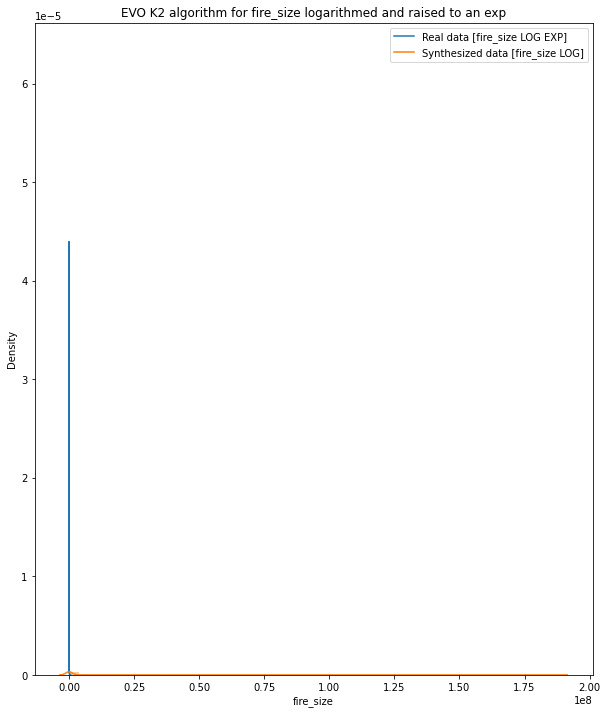

In [18]:
fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(np.exp(df_bayes['fire_size']), ax=ax)
sns.distplot(np.exp(synth_data_evok2['fire_size']), ax=ax)
ax.legend(['Real data [fire_size LOG EXP]', 'Synthesized data [fire_size LOG]'])
plt.title('EVO K2 algorithm for fire_size logarithmed and raised to an exp')
plt.show()